In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.dates import DateFormatter
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.preprocessing.sequence import TimeseriesGenerator

import warnings
warnings.filterwarnings('ignore')

### Import data

In [2]:
data = r"C:\Users\jim\Dropbox\Sample projects\Forecasting electricity market"
df = pd.read_csv(rf'{data}\european_wholesale_electricity_price_data_hourly\european_wholesale_electricity_price_data_hourly\Greece.csv')
df['date'] = pd.to_datetime(df['Datetime (UTC)'])
df.rename(columns = {'Price (EUR/MWhe)':'price'}, inplace = True)
#drop non-positive values
df = df[df["price"] >0 ]
df["year"] = df['date'].dt.year
df = df[["date", "price"]]
df.reset_index(drop=True, inplace=True)
df = df.set_index('date')

df.head()

,price
date,
2015-01-01 00:00:00,48.78
2015-01-01 01:00:00,31.10
2015-01-01 02:00:00,20.78
2015-01-01 03:00:00,25.40
2015-01-01 04:00:00,26.00


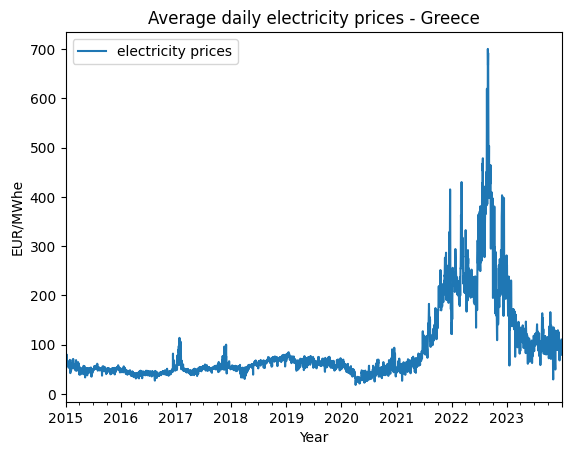

In [3]:
#Average daily prices

# Given there's no missing data, we can resample the data to daily level
daily_data = df.resample(rule='D').mean()

# Set frequency explicitly to D
daily_data = daily_data.asfreq('D')

daily_data.head(10)

daily_data.plot()
plt.xlabel("Year")
plt.ylabel("EUR/MWhe")
plt.title("Average daily electricity prices - Greece")
plt.legend(["electricity prices"])
plt.show()

### Seasonal Decomposition

Figure(640x480)


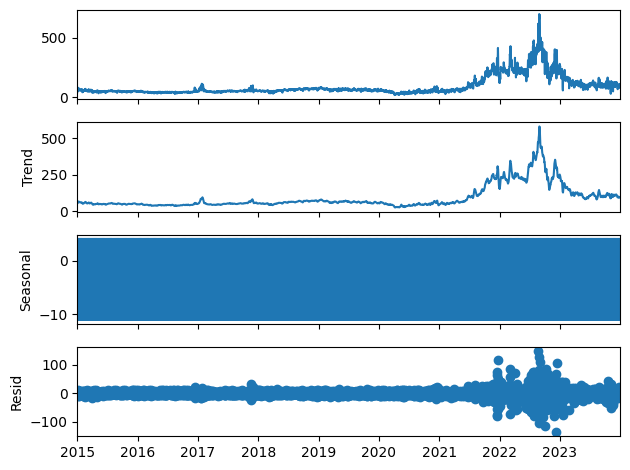

In [4]:
decomposition = seasonal_decompose(daily_data, model='additive')

fig = decomposition.plot()

print(fig)

plt.show()

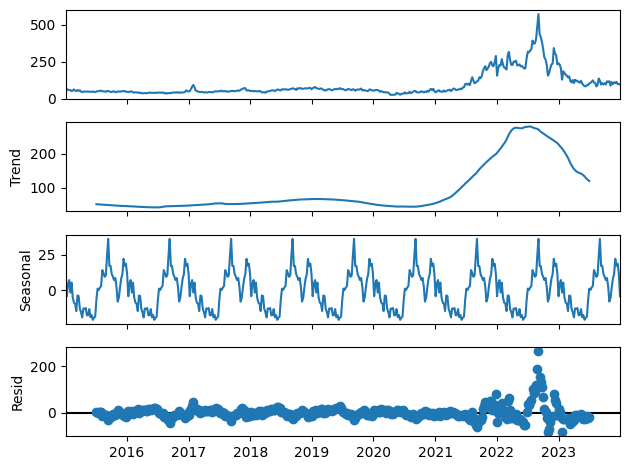

In [5]:
# Average weekly prices
weekly_data = df.resample(rule='W').mean()
decomposition = seasonal_decompose(weekly_data, model='additive') # Bring it to weekly level

fig = decomposition.plot()
plt.show()

### Visualise daily prices

Text(0.5, 1.0, 'Average electricity prices by day of week')

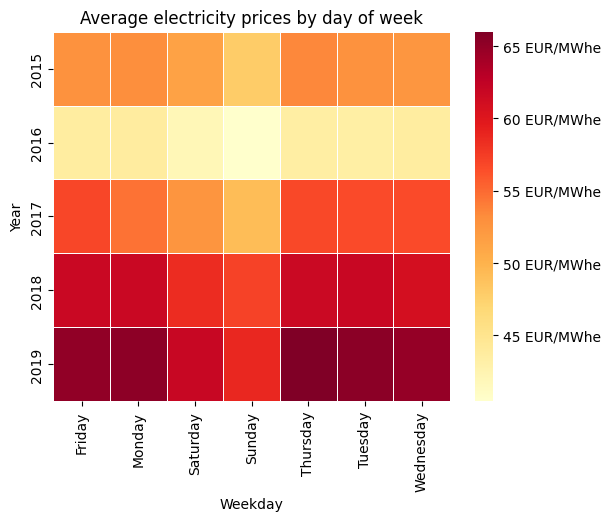

In [6]:
# Create new dataset for heatmap
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Weekday'] = daily_data.index.day_name()

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Weekday']).mean()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We produce the heatmap for the period 2015-2019 because from 2022 onwards there are a lot of jumps (covid, energy crisis etc.)
heatmap_data = heatmap_data[heatmap_data['Year'] < 2020]


# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Weekday', values='price')

# Visualise electricity load via Heatmap

sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f EUR/MWhe'}).set_title('Average electricity prices by day of week')

### Visualise for hours in the day

Text(0.5, 1.0, 'Average electricity prices by hour of day (UTC time)')

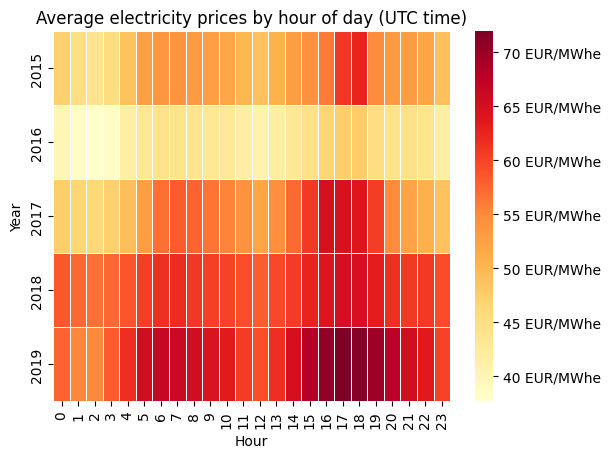

In [7]:
# Create new dataset for heatmap
heatmap_data = df.copy()

# First we need to add weekdays as a column
heatmap_data['Hour'] = df.index.hour

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Hour']).mean()

# Reset index 
heatmap_data = heatmap_data.reset_index()

# We produce the heatmap for the period 2015-2019 because from 2022 onwards there are a lot of jumps (covid, energy crisis etc.)
heatmap_data = heatmap_data[heatmap_data['Year'] < 2020]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Hour', values='price')

heatmap_data.head(100)

# Visualise electricity load via Heatmap

sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f EUR/MWhe'}).set_title('Average electricity prices by hour of day (UTC time)')

### Visualise monthly prices

Text(0.5, 1.0, 'Average electricity prices by day of month')

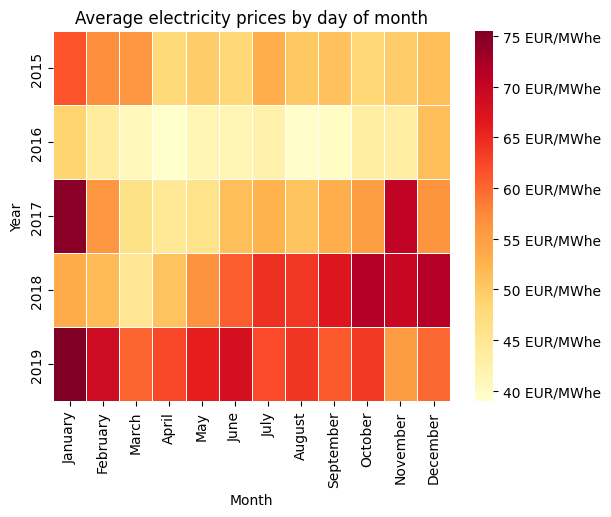

In [8]:
# Create new dataset for heatmap
heatmap_data = daily_data.copy()

# First we need to add weekdays as a column
heatmap_data['Month'] = daily_data.index.month_name()

# Next we add the year as column and group the data up to annual day of week level
heatmap_data['Year'] =  heatmap_data.index.year
heatmap_data = heatmap_data.groupby(['Year', 'Month']).mean()

# Reset index
heatmap_data = heatmap_data.reset_index()

# We produce the heatmap for the period 2015-2020 because after that period prices surged
heatmap_data = heatmap_data[heatmap_data['Year'] < 2020]

# Pivot it to a uniform data format for heatmaps
heatmap_data = heatmap_data.pivot(index='Year', columns='Month', values='price')

# Reorder columns
heatmap_data = heatmap_data[['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']]

heatmap_data.head(10)

# Visualise electricity load via Heatmap
sns.heatmap(heatmap_data, linewidths=.5, cmap='YlOrRd', cbar=True, cbar_kws={"format": '%1.0f EUR/MWhe'}).set_title('Average electricity prices by day of month')

## Forecasting models

### (i) RNN model

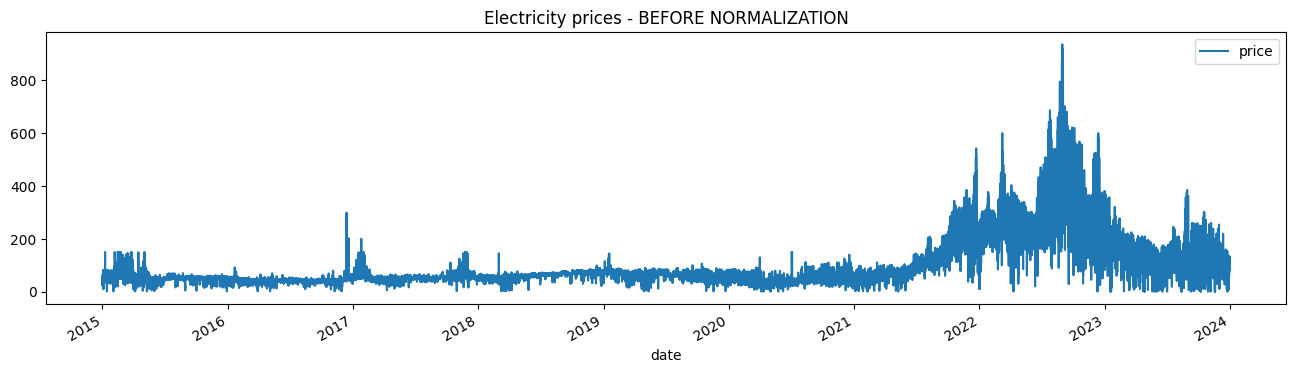

In [9]:
df.plot(figsize=(16,4),legend=True)
plt.title('Electricity prices - BEFORE NORMALIZATION')
plt.show()

**Normalize the data**

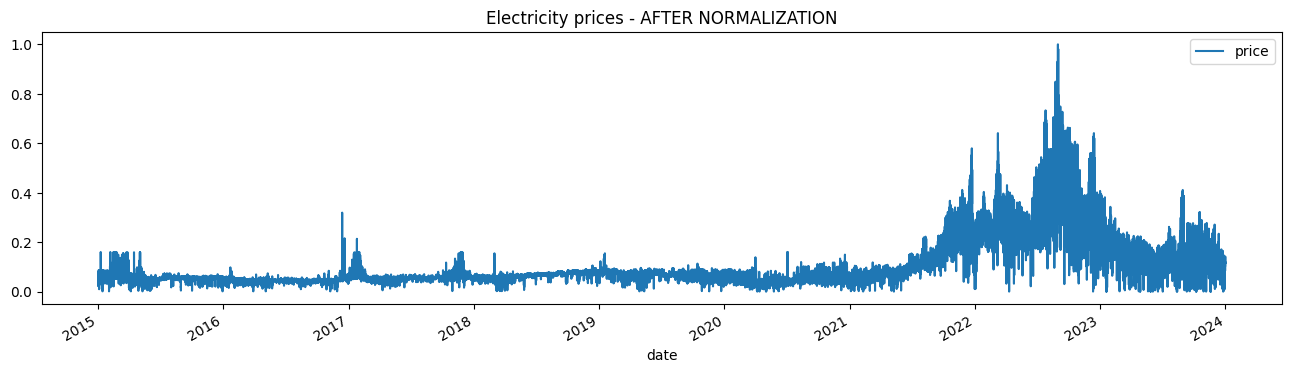

In [10]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['price']=scaler.fit_transform(df['price'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

df_norm.plot(figsize=(16,4),legend=True)
plt.title('Electricity prices - AFTER NORMALIZATION')
plt.show()

**Split training vs test data**

In [11]:
# Training data: from 1 Jan 2015 to 31 Dec 2021
# Test data: from 1 Jan 2022 to 31 Dec 2024
n = 61271

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)-5):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i+5, 0])

    #1 last n days are going to be used in test
    X_test = X_train[n:]             
    y_test = y_train[n:]
    
    #2 first n days are going to be used in training
    X_train = X_train[:n]          
    y_train = y_train[:n]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (n, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

**Define a function to plot actual vs predicted data**

In [12]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual electricity prices')
    plt.plot(predicted, alpha=0.8, color='orange',label='Predicted electricity prices')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized electricity prices scale')
    plt.legend()
    plt.show()

**Parametrization**

In [13]:
epochs = 30
units = 40
dropout = 0.15
batch = 1024
seq_len = 24*7 #choose sequence length. I choose 24hours*7 days due to a high seasonality observed at weekly level


**Run Simple RNN model and find the optimal $R^2$ value**

X_train.shape =  (61271, 168, 1)
y_train.shape =  (61271,)
X_test.shape =  (17318, 168, 1)
y_test.shape =  (17318,)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 168, 40)           1680      
                                                                 
 dropout (Dropout)           (None, 168, 40)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 168, 40)           3240      
                                                                 
 dropout_1 (Dropout)         (None, 168, 40)           0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 40)                3240      
                                                                 
 dropout_2 (Dropout)         (None, 40)                0         
     

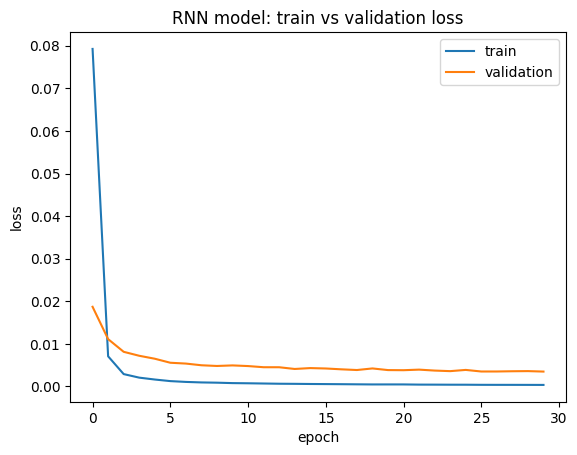

542/542 [==============================] - 11s 20ms/step
Average prices under current predictions: 0.20295298
R^2 Score of RNN model =  0.7893222445644504


In [14]:
X_train, y_train, X_test, y_test = load_data(df_norm, seq_len)
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

rnn_model = Sequential()

rnn_model.add(SimpleRNN(units,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(dropout))

rnn_model.add(SimpleRNN(units,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(dropout))

rnn_model.add(SimpleRNN(units,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(dropout))

rnn_model.add(Dense(1))

rnn_model.summary()

rnn_model.compile(optimizer="adam",loss="MSE")
history= rnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), batch_size=batch)

# plot train and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('RNN model: train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

rnn_predictions = rnn_model.predict(X_test)
print("Average prices under current predictions:", rnn_predictions.mean())

rnn_score = r2_score(y_test,rnn_predictions)
print("R^2 Score of RNN model = ",rnn_score)

### (ii) LSTM model

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 168, 40)           6720      
                                                                 
 dropout_3 (Dropout)         (None, 168, 40)           0         
                                                                 
 lstm_1 (LSTM)               (None, 168, 40)           12960     
                                                                 
 dropout_4 (Dropout)         (None, 168, 40)           0         
                                                                 
 lstm_2 (LSTM)               (None, 40)                12960     
                                                                 
 dropout_5 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

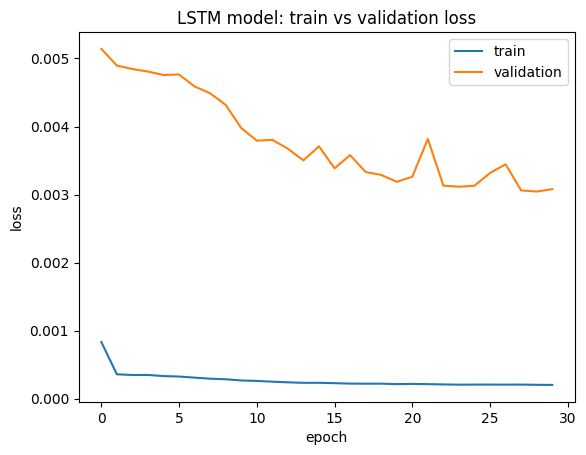

542/542 [==============================] - 32s 56ms/step
Average prices under current predictions: 0.21035917
R^2 Score of LSTM model =  0.8140709073748251


In [15]:
lstm_model = Sequential()

lstm_model.add(LSTM(units,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(dropout))

lstm_model.add(LSTM(units,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(dropout))

lstm_model.add(LSTM(units,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(dropout))

lstm_model.add(Dense(1))

lstm_model.summary()

lstm_model.compile(optimizer="adam",loss="MSE")
history_lstm=lstm_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test),batch_size=batch)

# plot train and validation loss
plt.plot(history_lstm.history['loss'])
plt.plot(history_lstm.history['val_loss'])
plt.title('LSTM model: train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

lstm_predictions = lstm_model.predict(X_test)
print("Average prices under current predictions:", lstm_predictions.mean())

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

### Comparison: Actual data vs simple RNN vs LSTM

 
Plot both predictions together:


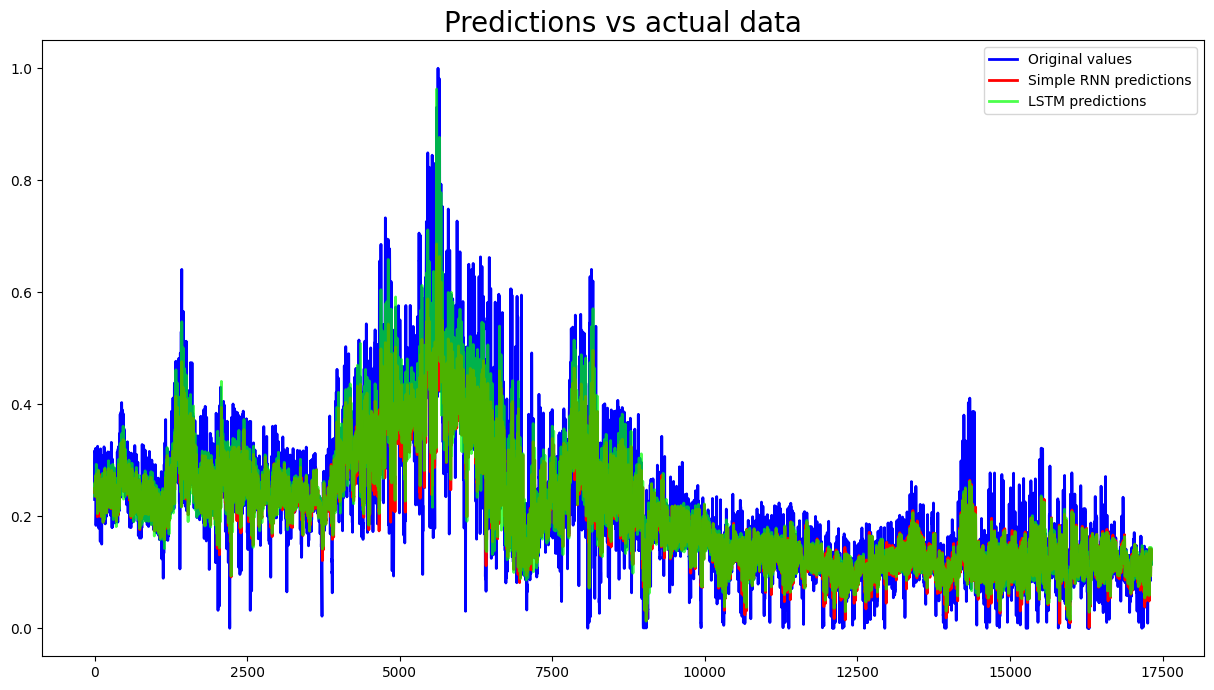

In [16]:
print(" ")
print("Plot both predictions together:")

plt.figure(figsize=(15,8))

plt.plot(y_test, c="blue", linewidth=2, label="Original values")
plt.plot(rnn_predictions, c="red", linewidth=2, label="Simple RNN predictions")
plt.plot(lstm_predictions, alpha=0.7, c="lime", linewidth=2, label="LSTM predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

In [17]:
df_y_test = pd.DataFrame(y_test)
df_y_test.rename(columns = {0 :'y_test'}, inplace = True)
df_rnn_pred = pd.DataFrame(rnn_predictions)
df_rnn_pred.rename(columns = {0 :'RNN_pred'}, inplace = True)
df_lstm_pred = pd.DataFrame(lstm_predictions)
df_lstm_pred.rename(columns = {0 :'LSTM_pred'}, inplace = True)
predictions = pd.merge(df_rnn_pred, df_lstm_pred, left_index=True, right_index=True)
pred_test = pd.merge(df_y_test, predictions, left_index=True, right_index=True)


In [18]:
pred_test.to_csv(rf'{data}\output\pred_test.csv')